# Modelado usando Prophet by Facebook

**Objetivo:** Seleccionar y aplicar un modelo predictivo para estimar la frecuencia de los accidentes.

## Prophet by Facebook
El modelo Prophet by Facebook tiene como principal característica que expresa las series de tiempo como la suma de tres componentes en función del tiempo: la tendencia **g(t)**, la estacionalidad **s(t)** y los días festivos **h(t)**.

![the-prophet-model](https://imgur.com/ySBxmcn.jpg)

La tendencia **g(t)** es la función que modela los cambios no periódicos de la variable objetivo. **s(t)** modela los cambios periódicos (que pueden ser semanales, mensuales o anuales) y **h(t)** modela el efecto de los días festivos en el incremento (o decremento) de la variable objetivo. Finalmente, epsilon representa el término de error del valor que no está representado por ninguno de los componentes anteriores (y se asume sigue una distribución normal).

Cuando **g(t)** se comporta de forma lineal tiene la siguiente forma:
![growth-rate](https://imgur.com/2kZYudw.jpg)

donde **k** es un ratio de crecimiento, que para hacerlo dependiente del tiempo se crea δ, un vector con aquellos puntos específicos que se identifican como momentos del tiempo donde los valores de la variable objetivo crecen. 

a(t) es un vector que se encarga de que el valor de **k** sea la suma de dichos momentos en el tiempo solo hasta el momento actual del entrenamiento.

**m** funciona como neutralizador del tiempo t.

El componente de estacionalidad utiliza la suma de N componentes de la serie de fourier para modelar los patrones que ocurren en un periodo P.
![seasonality-model](https://imgur.com/uiyY7jT.jpg)

Finalmente el componente de los días festivos utiliza Z(t) el cual regresa 1 si el momento t es un día festivo, es decir que el día festivo tendrá un efecto sobre la predicción con valor **k**.

![holiday-model](https://imgur.com/vNfND91.jpg)

## Implementación en Python
Para implementar el modelo en Python es necesario primero tener los datos correctos, para ello se construye el dataset que expresa la frecuencia diaria de los accidentes de tráfico en Barranquilla desde 2015 hasta 2018.

### Modelo base

In [23]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
import holidays

df = pd.read_csv('../../data/processed/Accidentes_clean.csv')
df['FECHA_ACCIDENTE'] = pd.to_datetime(df['FECHA_ACCIDENTE'], format="%Y-%m-%d %H:%M:%S")
daily_data = df.set_index('FECHA_ACCIDENTE').groupby(pd.Grouper(freq='d')).agg({'CANTIDAD_ACCIDENTES':sum}).reset_index()
daily_data.head()

,FECHA_ACCIDENTE,CANTIDAD_ACCIDENTES
0,2015-01-01,10
1,2015-01-02,13
2,2015-01-03,11
3,2015-01-04,7
4,2015-01-05,14


Luego, se divide el dataset de tal forma que se tenga sólo los datos de entrenamiento, para este caso se escogen todos los registros desde 2015 hasta 2017. Como test de validación se utilizará los accidentes del año 2018.

In [24]:
df = daily_data.set_index('FECHA_ACCIDENTE')
train = df.loc[:'2017-12-31'].reset_index()
train.columns = ['ds', 'y']
train.head()

,ds,y
0,2015-01-01,10
1,2015-01-02,13
2,2015-01-03,11
3,2015-01-04,7
4,2015-01-05,14


Se entrena el modelo con el dataset de entrenamiento creado.

In [25]:
model = Prophet()
model.fit(train)

C:\Users\danie\AppData\Local\conda\conda\envs\barranquilla-accidents\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\danie\AppData\Local\conda\conda\envs\barranquilla-accidents\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Se hace la predicción del test set y se evalúa su rendimiento para crear el modelo personalizado.

In [26]:
test = df.loc['2018-01-01':].reset_index()

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1456,2018-12-27,16.960957,9.097608,20.883346,16.859167,17.064121,-2.042069,-2.042069,-2.042069,0.751231,0.751231,0.751231,-2.793299,-2.793299,-2.793299,0.0,0.0,0.0,14.918888
1457,2018-12-28,16.960074,10.591415,22.185255,16.857645,17.064097,-0.738601,-0.738601,-0.738601,2.401138,2.401138,2.401138,-3.139739,-3.139739,-3.139739,0.0,0.0,0.0,16.221473
1458,2018-12-29,16.959191,7.764505,20.179106,16.856268,17.064073,-3.258635,-3.258635,-3.258635,0.210473,0.210473,0.210473,-3.469108,-3.469108,-3.469108,0.0,0.0,0.0,13.700556
1459,2018-12-30,16.958308,1.162298,13.494587,16.855019,17.063789,-9.711955,-9.711955,-9.711955,-5.935416,-5.935416,-5.935416,-3.776538,-3.776538,-3.776538,0.0,0.0,0.0,7.246353
1460,2018-12-31,16.957425,6.153227,18.205917,16.853780,17.063303,-4.467692,-4.467692,-4.467692,-0.410236,-0.410236,-0.410236,-4.057456,-4.057456,-4.057456,0.0,0.0,0.0,12.489733


#### Predicción
A continuación se presenta un gráfico de línea que ilustra la predicción del modelo con una línea roja y los valores reales con una línea azul. 

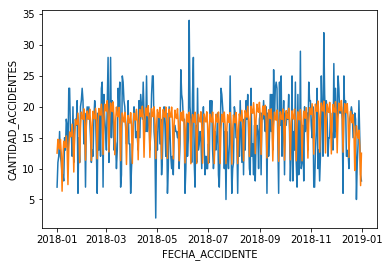

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.lineplot(x=test['FECHA_ACCIDENTE'], y=test['CANTIDAD_ACCIDENTES'], ax=ax)
sns.lineplot(x=test['FECHA_ACCIDENTE'], y=forecast['yhat'].iloc[-365:].values, ax=ax)
plt.show()

#### Componentes del modelo
A continuación se presentan gráficas de la tendencia general del modelo, el patrón semanal y anual encontrado automáticamente.

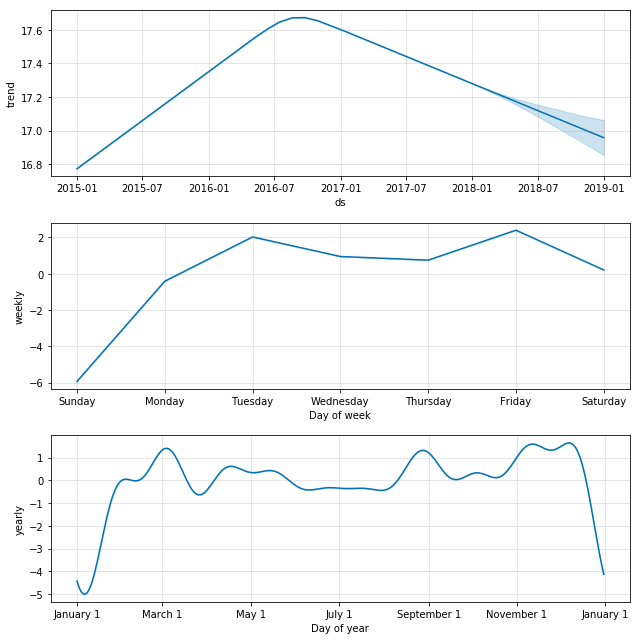

In [28]:
fig2 = model.plot_components(forecast)

#### Evaluación del modelo al predecir 2018
Se calcula el error cuadrático medio y el error absoluto medio para el año 2018.

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print('MSE: {0}'.format(mean_squared_error(test['CANTIDAD_ACCIDENTES'].values, forecast['yhat'].iloc[-365:].values)))
print('MAE: {0}'.format(mean_absolute_error(test['CANTIDAD_ACCIDENTES'].values, forecast['yhat'].iloc[-365:].values)))

MSE: 23.888128145300637
MAE: 3.9395668100242127


### Modelo Personalizado
Al modelo personalizado se le edita la búsqueda automática de patrones para incluirmos manualmente. Los patrones anuales, semanales y diarios son incluidos a partir de los encontrádos en el análsis previo. Adicionalmente, se le añade al modelo el efecto de días festivos en Colombia.

In [30]:
custom_model = Prophet(
    growth="linear",
    seasonality_mode="additive",
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=10
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=20
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=10
)
custom_model.add_country_holidays(country_name='CO')
custom_model.fit(train)

future = custom_model.make_future_dataframe(periods=365)
forecast = custom_model.predict(future)

from sklearn.metrics import mean_squared_error, mean_absolute_error
print('MSE: {0}'.format(mean_squared_error(test['CANTIDAD_ACCIDENTES'].values, forecast['yhat'].iloc[-365:].values)))
print('MAE: {0}'.format(mean_absolute_error(test['CANTIDAD_ACCIDENTES'].values, forecast['yhat'].iloc[-365:].values)))

C:\Users\danie\AppData\Local\conda\conda\envs\barranquilla-accidents\lib\site-packages\fbprophet\forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
C:\Users\danie\AppData\Local\conda\conda\envs\barranquilla-accidents\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


MSE: 21.756546435935043
MAE: 3.732595977935916


#### Componentes del modelo

A continuación, se presentan gráficas con la tendencia general del modelo, el efecto de días festivos, los patrones semanales, los patrones anuales y los patrones diarios incluidos.

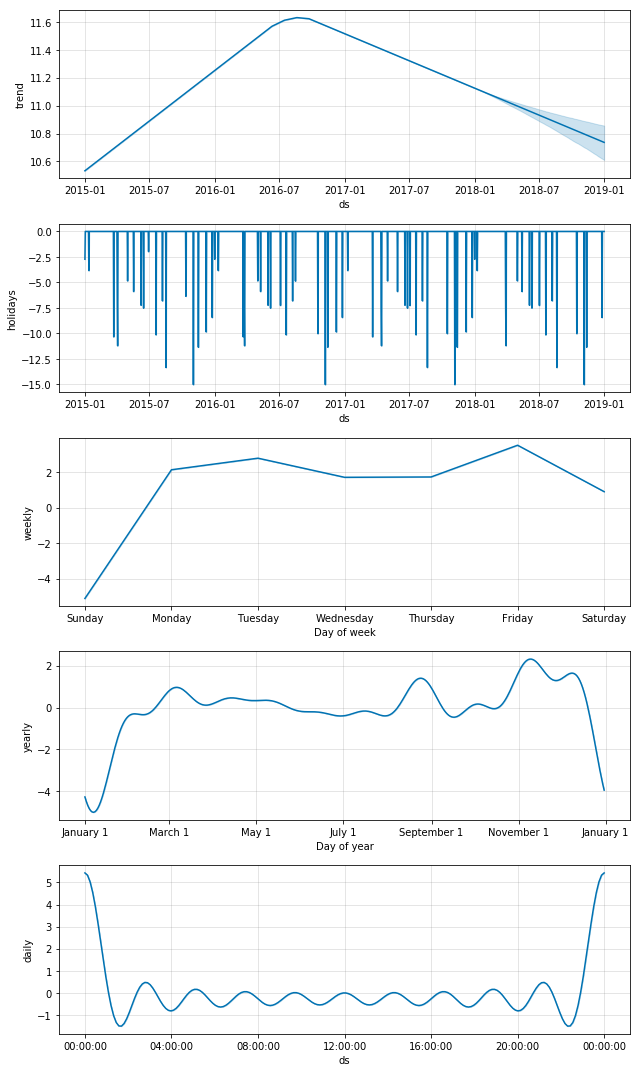

In [31]:
fig2 = custom_model.plot_components(forecast)

#### Predicción año 2018
A continuación se presenta un gráfico de línea donde la predicción para el año 2018 está representada por una línea roja mientras que los valores reales de dicho año están representados por una línea azul.

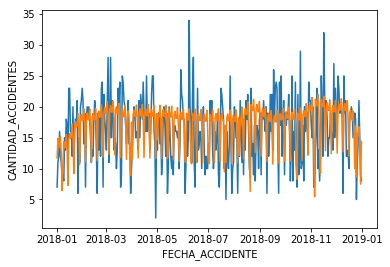

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.lineplot(x=test['FECHA_ACCIDENTE'], y=test['CANTIDAD_ACCIDENTES'], ax=ax)
sns.lineplot(x=test['FECHA_ACCIDENTE'], y=forecast['yhat'].iloc[-365:].values, ax=ax)
plt.show()

#### Binarios del modelo
Como paso final, se guarda el modelo entrenado como un objeto serealizado para su despliegue.

In [33]:
import pickle
filename = '../../model/test models/prophet_model.sav'
pickle.dump(custom_model, open(filename, 'wb'))